# New Pipeline

## Setup

In [21]:
%%capture
#!pip install google-colab
!pip install sentence_transformers
#!pip install setfit
!pip install imblearn
!pip install rapidfuzz
!pip install seaborn
!pip install rapidfuzz

In [ ]:
# if in colab
#from google.colab import drive
#drive.mount('/content/drive')

In [22]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, cohen_kappa_score
from sentence_transformers import SentenceTransformer
import os
import json
import time
#import cupy as cp
import random
from tqdm import tqdm
#r = random.Random(9)
#random.seed(9)
from rapidfuzz import fuzz

In [23]:
from latent_embeddings_classifier import *
from utils import *
from model_evaluator import *

In [24]:
cwd = os.getcwd()
print(cwd)

# if in colab
#os.listdir(cwd+"/drive/MyDrive/PhD/CoLabs")
input_path = cwd+"/drive/MyDrive/PhD/CoLabs/admin.json"
output_dir =  cwd+"/drive/MyDrive/PhD/CoLabs/"
full_inp_path = cwd+"/drive/MyDrive/PhD/CoLabs/ForestLablTmp_prelab.json"

# if on laptop
output_dir =  cwd+"../../outputs"
input_dir =  cwd+"../../inputs"
#input_path = cwd+"/../../../../Downloads/admin.json"
#input_path = input_dir+"/01Nov2024_first_dataset.json"
#full_inp_path = cwd+"/../../policy-classifier/populate_corpora/outputs/ForestLablTmp_prelab.json"

c:\Users\allie\Documents\GitHub\policy-classifier\classifier


## Function Definitions

### Data Preparation

In [5]:
def group_duplicates(sents, labels, thresh = 90):
    '''
    Returns dictionary containing lists of sentence, label tuples in levenshtein groups.
    '''
    groups = []
    indices = set()
    # Group sentences by similarity
    for i, senti in enumerate(sents):
        # if i is already in indices, move on to next index
        if i in indices:
            continue
        new_group = [(senti, labels[i])]
        indices.add(i)
        for j, sentj in enumerate(sents):
            # only check sentences after current sentence [since prev sents will
            # already have been processed] and make sure sentence hasn't already
            # been added to another group [in indices]
            if j > i and j not in indices:
                lvnst = fuzz.ratio(senti, sentj)
                if lvnst >= thresh:
                    new_group.append((sentj, labels[j]))
                    indices.add(j)
        groups.append(new_group)
    print(f'{len(groups)} groups found with a threshold of {thresh}')
    # Convert groups to a dictionary with labels
    lvnst_grps = {}
    for i, group in enumerate(groups):
        lvnst_grps[f"group_{i}"] = group
    return lvnst_grps

def remove_duplicates(lvnst_grps):
    '''
    For dictionary of levenshtein groups, returns sentences, labels having
    converted each group into a single sentence, label entry.
    '''
    sents = []
    labels = []
    for group in lvnst_grps:
        sents.append(lvnst_grps[group][0][0])
        labels.append(lvnst_grps[group][0][1])
    print(f'Sanity check: {len(sents)} sentences and {len(labels)} labels')
    return sents, labels

def dcno_to_sentlab(dcno_json, sanity_check=False):
    '''
    For a json exported from doccano and read into a python dictionary,
    return the sentences and labels.
    '''
    sents = []
    labels = []
    for entry in dcno_json:
        if entry["label"] != []:
            if entry["label"][0].lower() !="unsure":
                sents.append(entry["text"])
                labels.append(entry["label"][0])
    if sanity_check:
        print(f'Sanity Check: {len(sents)} sentences and {len(labels)} labels')
        #for i in range(2):
        #    n = random.randint(0, len(sents))
        #    print(f'[{n}] {labels[n]}: {sents[n]}')
    return sents, labels

# processing start

def gen_bn_lists(sents, labels, sanity_check=False):
    '''
    This gets the lists of the sentences for the binary classification: one list of incentives, one of non-incentives.
    inputs:
    sents - list of sentences
    labels - labels
    returns:
    inc - incentive sentences
    noninc - nonincentive sentences
    '''
    inc =[]
    noninc =[]
    for sent, label in zip(sents, labels):
        if label.lower() == "non-incentive":
            noninc.append(sent)
        else:
            inc.append(sent)
    if sanity_check:
        i = len(inc)
        n = len(noninc)
        print(f'Sanity Check: {i} incentive sentences and {n} non-incentive sentences')
        print(f'Incentives: {i/(i+n)}; Non-Incentives: {n/(i+n)}')
        #n = random.randint(0, len(inc))
        #print(f'[{n}] Incentive: {inc[n]}')
        #n = random.randint(0, len(noninc))
        #print(f'[{n}] Non-Incentive: {noninc[n]}')
    return inc, noninc

def gen_mc_sentlab(sents, labels, sanity_check=False):
    '''
    This fxn takes the list of sentences and the labels aggregated in the different methods
    and returns the incentive-specific sentences
    inputs:
    sents - list of sentences
    labels - labels
    outputs:
    sents - classified incentive sentences
    labs - classified incentive labels
    '''
    mc_sents = []
    mc_labels = []
    for sent, label in zip(sents, labels):
        if label.lower() == "non-incentive":
            continue
        else:
            mc_sents.append(sent)
            mc_labels.append(label)
    if sanity_check:
        print(f'Sanity Check: {len(mc_sents)} incentive sentences and {len(mc_labels)} incentive labels')
        #for i in range(5):
        #    n = random.randint(0, len(mc_sents))
        #    print(f'[{n}] {mc_labels[n]}: {mc_sents[n]}')
    return mc_sents, mc_labels

### Data Augmentation

In [6]:
# adapted from old repo
import textwrap

# Model libraries
from scipy.spatial import distance
import numpy as np

from json import JSONEncoder

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [7]:
QUERIES_DCT = {
  "This scheme gives farmers greater access to financial loans and encourages financial planning." : "Credit",
  "National initiatives, such as the Future Growth Loan Scheme, supports strategic long-term capital investment by providing competitively priced loan instruments under favourable terms." : "Credit",
  "Harvest and production insurance that contributes to safeguarding producers' incomes where there are losses as a consequence of natural disasters, adverse climatic events, diseases or pest infestations while ensuring that beneficiaries take necessary risk prevention measures." : "Credit",
  "The Department of Agriculture Food and the Marine has funded a number of loan schemes which provide access to finance for famers in Ireland, enabling them to maintain liquidity and ensure they can take investment decisions tailored to their enterprise" : "Credit",
  "In cases where a loan is used to finance or top up a mutual fund no distinction is made between the basic capital and loans taken out in respect of the replenishment of the fund following compensate to growers." : "Credit",
  "The Scheme is supporting generational renewal on Irish farms by allowing young farmers to avail of a higher grant rate of 60% (with a standard grant rate of 40% available to all other applicants)." : "Direct_payment",
  "This programme incorporated extra payments on top of the basic REPS premium for farmers who undertook additional environmentally friendly farming practices." : "Direct_payment",
  "Forestry Programme 2014 -2020 providing grants and / or annual premiums for establishment, development and reconstitution of forests, woodland improvement, native woodland conservation." : "Direct_payment",
  "In addition to providing a basic income support to primary producers and achieving a higher level of environmental ambition, Pillar I (direct payments) interventions are aimed at achieving a fairer approach to the distribution of payments in Ireland." : "Direct_payment",
  "Decision to set an amount of direct payments not higher than EUR 5 000 under which farmers shall in any event be considered as ‘active farmers.’" : "Direct_payment",
  "Landowners found burning illegally could face fines, imprisonment and Single Farm Payment penalties, where applicable." : "Fine",
  "In the absence of abatement strategies, ammonia emissions are forecast to increase which may result either in substantial fines or the imposition of a de-facto quota based on emission levels." : "Fine",
  "If an offence is committed by a public body, and is committed with the consent of, or is attributable to the neglect on the part of a director, manager or other officer of the public body, that person will also be liable for prosecution; on conviction, fines up to €250,000 or imprisonment for up to 2 years, or both, may be imposed 125 Per s ection 14A(6) of the Act." : "Fine",
  "In addition, a fine will apply which will be calculated on the difference between the area declared and the area determined." : "Fine",
  "Where trees have been—(a) felled or otherwise removed without a licence under section 7,(b) felled under a licence and, either at the time of such felling or subsequently, a condition of the licence is contravened, or(c) in the opinion of the Minister, seriously damaged, the Minister may issue a replanting order in respect of the owner requiring him or her to replant or to fulfil any or all of the conditions that attached to the licence (or, in a case in which no licence was granted, any or all of the conditions that would, in the opinion of the Minister, have been attached to a licence had such been granted) in accordance with the provisions of the orderSections 27-29 detail offences and corresponding penalties, from fixed penalties to (on conviction) substantial fines and imprisonment." : "Fine",
  "Similarly, the On-Farm Capital Investments Scheme has provisions for investments in equipment that will allow farmers to reduce the amount of Green House Gas emissions that they produce during their agricultural practices." : "Supplies",
  "The intervention also supports investments that allow farmers to acquire technologies and equipment that increases their efficiencies and climate adaptation potential thus addressing Obj4N4 and Obj4N5." : "Supplies",
  "Grants are provided for farmers wishing to invest in productive technologies and or equipment." : "Supplies",
  "Support provided under this scheme will directly address Obj5N1 and Obj5N2 by providing an incentive to farmers to invest in machinery and equipment that better protects air and water quality." : "Supplies",
  "The On Farm Capital Investment Scheme also addresses Obj9N1 by providing a higher grant rate of support for investments in organic farming materials/equipment, at a higher rate of 60% in comparison to the rate of 40% for general investments." : "Supplies",
  "To complement the EXEED programme, the tax code provides for accelerated capital allowances (ACAs) for energy efficient equipment supporting the reduction of energy use in the workplace and the awareness of energy efficiency standards in appliances." : "Tax_deduction",
  "A tax incentive for companies paying corporation tax is also in place in the form of accelerated capital allowance for energy efficient equipment." : "Tax_deduction",
  "The Accelerated Capital Allowance (ACA) is a tax credit that encourages the purchase of energy -efficient goods" : "Tax_deduction",
  "These include the granting of an enhanced 50% stock tax relief to members of registered farm partnerships; the recognition of such arrangements in the calculation of payments under the Pillar I and Pillar II Schemes; and the introduction of a Support for Collaborative Farming Grant Scheme for brand new farm partnerships." : "Tax_deduction",
  "We are committed to further developing a taxation framework, which plays its full part in incentivising, along with other available policy levers, the necessary actions to reduce our emissions" : "Tax_deduction",
  "The Knowledge Transfer (KT) initiative is a significant investment in high quality training and upskilling of farmers so that they are equipped to deal with the range of challenges and opportunities arising in the agri-food sector." : "Technical_assistance",
  "The associated training will educate farmers on how to appropriately implement the actions of the scheme; thereby equipping them with the knowledge and skills necessary to optimise delivery and continue the ongoing management of the commitments undertaken; as well as to facilitate the implementation of high welfare practices." : "Technical_assistance",
  "This scheme has two measures: • provides financial support towards the professional costs, such as legal, taxation and advisory, incurred during the establishment of a Registered Farm Partnership." : "Technical_assistance",
  "LEADER may provide support rates greater than 65% in accordance with Article 73(4) (c)(ii) where investments include basic services in rural areas and infrastructure in agriculture and forestry , as determined by Member States" : "Technical_assistance",
  "It also assists and supports the delivery of capacity building and training programmes with the aim of equipping decision makers with the capability and confidence to analyse, plan for and respond to the risks and opportunities that a changing climate presents." : "Technical_assistance"
  }

In [8]:
def create_sentence_embeddings(model, sentences):
    embeddings = []
    for sentence in sentences:
        embeddings.append(model.encode(sentence.lower(), show_progress_bar=False))
    return embeddings

def sentence_similarity_search(model, queries, embeddings, sentences, similarity_limit, results_limit, cuda, prog_bar):
    results = {}
    for query in tqdm(queries):
        #Ti = time.perf_counter()
        similarities = get_distance(model, embeddings, sentences, query, similarity_limit, cuda, prog_bar)
        results[query] = similarities[0:results_limit] #results[transformer][query] = similarities[0:results_limit]
        #Tf = time.perf_counter()
        #print(f"Similarity search for query '{query}' has been done in {Tf - Ti:0.2f}s.")
    return results

def get_distance(model, embeddings, sentences, query, similarity_treshold, cuda, prog_bar):
    if cuda:
        query_embedding = model.encode(query.lower(), show_progress_bar=prog_bar, device='cuda')
    else:
        query_embedding = model.encode(query.lower(), show_progress_bar=prog_bar)
    highlights = []
    for i in range(len(sentences)):
        try:
            sentence_embedding = embeddings[i]
            score = 1 - distance.cosine(sentence_embedding, query_embedding)
            if score > similarity_treshold:
                highlights.append([i, score, sentences[i]])
        except KeyError as err:
            print(sentences[i])
            print(embeddings[i])
            print(err)
    highlights = sorted(highlights, key = lambda x : x[1], reverse = True)
    return highlights

# To show the contents of the results dict, particularly, the length of the first element and its contents
def show_results(results_dictionary):
    i = 0
    for key1 in results_dictionary:
        for key2 in results_dictionary[key1]:
            if i == 0:
                print(len(results_dictionary[key1][key2]))
                print(results_dictionary[key1][key2])
            i += 1

In [9]:
def run_embedder(sample=True, cuda=False, data=[], unique=False):
    script_info = "Running "
    if sample:
        script_info += "sample"
    else:
        script_info += "all sentences"
    if cuda:
        script_info += " on GPU."
    else:
        script_info += " on CPU."
    print(script_info)

    if unique:
        sentences = list(set(data))
    else:
        sentences = data

    if sample:
        #random.seed(9)
        sentences = random.sample(sentences, 10)

    Ti = time.perf_counter()

    transformer_name = 'xlm-r-bert-base-nli-stsb-mean-tokens'

    if cuda:
        model = SentenceTransformer(transformer_name, device="cuda")
    else:
        model = SentenceTransformer(transformer_name)

    print("Loaded model. Now creating sentence embeddings.")

    embs = create_sentence_embeddings(model, sentences)

    Tf = time.perf_counter()

    print(f"The building of a sentence embedding database in the current models has taken {Tf - Ti:0.2f}s.")

    return embs, sentences, model

def run_queries(embs, sentences, model, cuda=False, sim_thresh=0.6, res_lim=1000):
    prog_bar = False
    print("Now running queries.")

    queries = []
    for query in QUERIES_DCT:
        queries.append(query)

    #check_dictionary_values(queries_dict)

    results_dict = sentence_similarity_search(model, queries, embs, sentences, sim_thresh, res_lim, cuda, prog_bar)

    return results_dict

def pre_tag_parse(pretag):
    '''
    Preps dct for training
    '''
    sentences = []
    labels = []
    for query in list(pretag):
        for result in pretag[query]:
            sentences.append(result[2])
            labels.append(QUERIES_DCT[query])
    return sentences, labels

def convert_pretagged(pre_lab):
    '''
    Takes pre_tagged dct generated in assisted_labelling.py
    resolves the queries and keys
    '''
    qdct = QUERIES_DCT.copy()
    i=1
    for query in list(qdct):
        label = qdct[query]
        label += f"_{i%5}"
        qdct[query] = label
    new_dct = {}
    for qry in tqdm(list(pre_lab)):
        label = qdct[qry]
        for sent_unit in pre_lab[qry]:
            # the format has the sentence as the last element in the sublist
            sentence = sent_unit[-1]
            new_dct[sentence] = label
    return new_dct

def crossref_sents(pre_lab):
    new_dct = {}
    qdct = QUERIES_DCT.copy()
    # = set(qdct.values())
    # 'Fine', 'Tax_deduction', 'Supplies', 'Direct_payment', 'Credit', 'Technical_assistance'
    for qry in list(qdct):
        new_dct[qry]=[]
    # get dct of queries with lists of sentence results
    for query in list(pre_lab):
        for entry in pre_lab[query]:
            new_dct[query].append(entry[-1])
    return new_dct

### Data Filtering

In [10]:
from rapidfuzz import fuzz

# make into fxn dfns then run on both datasets

# 95 yeilded 637 groups
# 90 yeilded 625 groups
# now going to add unsures- 706 groups

def group_duplicates(qsents, qlabels, thresh = 90):
    '''
    If you want to create a dictionary
    '''
    groups = []
    # use set to avoid duplicate processing
    indices = set()

    # Group sentences by similarity
    for i, senti in enumerate(qsents):
        # if i is already in indices, move on to next index
        if i in indices:
            continue
        new_group = [(senti, qlabels[i])]
        indices.add(i)
        for j, sentj in enumerate(qsents):
            # only check sentences after current sentence [since prev sents will
            # already have been processed] and make sure sentence hasn't already
            # been added to another group [in indices]
            if j > i and j not in indices:
                lvnst = fuzz.ratio(senti, sentj)
                if lvnst >= thresh:
                    new_group.append((sentj, qlabels[j]))
                    indices.add(j)
        groups.append(new_group)
    print(f'{len(groups)} groups found with a threshold of {thresh}')
    # Convert groups to a dictionary with labels
    lvnst_grps = {}
    for i, group in enumerate(groups):
        lvnst_grps[f"group_{i}"] = group
    return lvnst_grps

def remove_duplicates(lvnst_grps):
    qsents = []
    qlabels = []
    for group in lvnst_grps:
        qsents.append(lvnst_grps[group][0][0])
        qlabels.append(lvnst_grps[group][0][1])
    print(f'Sanity check: {len(qsents)} sentences and {len(qlabels)} labels')
    return qsents, qlabels

### Classification

In [25]:
def classify_svm(train_embs, train_labels, test_embs, r_state= 9):
    print("Evaluating.")
    clf = svm.SVC(gamma=0.001, C=100., random_state=r_state)
    clf.fit(np.vstack(train_embs), train_labels)
    clf_preds = [clf.predict(sent_emb)[0] for sent_emb in test_embs]
    return clf_preds

### Binary Embedding

In [ ]:
def bn_generate_embeddings(incentives, nonincentives, cuda=False, r_state=9, exps=1, model_name= "paraphrase-xlm-r-multilingual-v1", sanity_check=False):
    '''
    Takes incentive and nonincentive sentences, creates corresponding 
    label lists, and merges them accordingly. Splits data into trainig
    and testing sets, initializes a sentence transformer model,
    creates embeddings of the training and test sentences,
    returns encoded training sents, test sents, and test labels
    '''
    raps = {}
    incent_lbls = ["incentive"]*len(incentives)
    noninc_lbls = ["non-incentive"]*len(nonincentives)
    sentences = incentives+nonincentives
    labels = incent_lbls+noninc_lbls
    dev = 'cuda' if cuda else None
    print("Loading model.")
    try:
        bin_model = SentenceTransformer(model_name, device=dev) # or .cuda()
    except:
        bin_model = SentenceTransformer(model_name, device=dev, trust_remote_code=True)
    for exp in range(exps):
        train_sents, test_sents, train_labels, test_labels = train_test_split(sentences,labels, test_size=0.2, random_state=exp)
        print("Encoding training sentences.")
        train_embs = encode_all_sents(train_sents, bin_model)
        print("Encoding test sentences.")
        test_embs = encode_all_sents(test_sents, bin_model)
        clf_prds = classify_svm(train_embs, train_labels, test_embs, r_state= r_state)
        raps[exp] = {'real': test_labels, 'pred': clf_prds}
    return raps

### Multiclass Embedding

In [27]:
def mc_generate_embeddings(sentences, labels, cuda=False, r_state=9, exps=1, model_name= "paraphrase-xlm-r-multilingual-v1", sanity_check=False):
    '''
    Takes sentences and labels. Splits data into trainig
    and testing sets, initializes a sentence transformer model,
    creates embeddings of the training and test sentences,
    returns encoded training sents, test sents, and test labels
    '''
    raps = {}
    # load model
    dev = 'cuda' if cuda else None
    print("Loading model.")
    try:
        bin_model = SentenceTransformer(model_name, device=dev) 
    except:
        bin_model = SentenceTransformer(model_name, device=dev, trust_remote_code=True)
    for exp in range(exps):
        train_sents, test_sents, train_labels, test_labels = train_test_split(sentences,labels, test_size=0.2, random_state=exp)
        label_names = list(set(train_labels))
        if sanity_check:
            print("Label names:", label_names)
            #n = random.randint(0, len(train_labels))
            #print(f"[{n}] {train_labels[n]}: {train_sents[n]}")
            #t = random.randint(0, len(test_labels))
            #print(f"[{t}] {test_labels[t]}: {test_sents[t]}")
        print("Encoding training sentences.")
        train_embs = encode_all_sents(train_sents, bin_model)
        print("Encoding test sentences.")
        test_embs = encode_all_sents(test_sents, bin_model)
        clf_prds = classify_svm(train_embs, train_labels, test_embs, r_state= r_state)
        raps[exp] = {'real': test_labels, 'pred': clf_prds}
    return raps

### Evaluation

In [80]:
def res_dct_to_cls_rpt(res_dct):
    cls_rpt = {
        'bn':{},
        'mc':{}
    }
    for mode in list(res_dct):
        for model in list(res_dct[mode]):
            cls_rpt[mode][model] = {}
            for exp in list(res_dct[mode][model]):
                cls_rpt[mode][model][exp] = classification_report(res_dct[mode][model][exp]['real'], res_dct[mode][model][exp]['pred'], output_dict=True)
    return cls_rpt

def cls_rpt_to_exp_rpt(cls_rpt):
    '''
    Takes dictionary of classification reports and returns dictionary of
    each classification model's average and sd values for accuracy and label
    f1-scores across the experiments.
    '''
    exp_rpt = {
        'bn':{},
        'mc':{}
    }
    for mode in list(cls_rpt):
        for model in list(cls_rpt[mode]):
            if mode == 'mc':
                exp_rpt[mode][model] = {
                    "accuracy": {},
                    "macroavg-f1": {},
                    "weightavg-f1": {},
                    "labels": {
                        'Credit':{},
                        'Direct_payment':{},
                        'Fine':{},
                        'Supplies':{},
                        'Tax_deduction':{},
                        'Technical_assistance':{}
                    }
                }
            else:
                exp_rpt[mode][model]= {
                    "accuracy": {},
                    "macroavg-f1": {},
                    "weightavg-f1": {},
                    "labels": {
                        'incentive':{},
                        'non-incentive':{}
                    }
                }
            accuracy = []
            macrof1 = []
            wghtf1=[]
            label_f1s = {}
            for label in list(exp_rpt[mode][model]["labels"]):
                label_f1s[label]=[]
            for exp in list(cls_rpt[mode][model]):
                try:
                    accuracy.append(cls_rpt[mode][model][exp]['accuracy'])
                    macrof1.append(cls_rpt[mode][model][exp]['macro avg']["f1-score"])
                    wghtf1.append(cls_rpt[mode][model][exp]['weighted avg']["f1-score"])
                except:
                    print(f'\nCould not add accuracy from {mode} {model} exp:{exp}')
                for label in list(exp_rpt[mode][model]["labels"]):
                    try:
                        label_f1s[label].append(cls_rpt[mode][model][exp][label]["f1-score"])
                    except:
                        print(f'\nCould not add F1 score for {label} in {mode} {model} exp:{exp}')
            exp_rpt[mode][model]['accuracy'] = {'average':np.average(accuracy), 'sd': np.std(accuracy)}
            exp_rpt[mode][model]['macroavg-f1'] = {'average':np.average(macrof1), 'sd': np.std(macrof1)}
            exp_rpt[mode][model]['weightavg-f1'] = {'average':np.average(wghtf1), 'sd': np.std(wghtf1)}
            for label in list(exp_rpt[mode][model]["labels"]):
                exp_rpt[mode][model]["labels"][label] = {'average':np.average(label_f1s[label]), 'sd': np.std(label_f1s[label])}
    return exp_rpt

## Inter Annotator Agreement

### Extracting Subset

In [46]:
def label_dct(djson):
  rev_lib = {}
  for entry in djson:
        if entry["label"][0] not in rev_lib.keys():
          rev_lib[entry["label"][0]] = [entry["text"]]
        else:
          rev_lib[entry["label"][0]].append(entry["text"])
  return rev_lib

def resample_dict(label_lib):
  sampled_dct = {}
  labels = list(set(label_lib.keys()))
  labels.remove('Non-Incentive')
  for incentive in labels:
    if len(label_lib[incentive]) < 10:
      sampled_dct[incentive] = random.sample(label_lib[incentive], len(label_lib[incentive]))
    else:
      sampled_dct[incentive] = random.sample(label_lib[incentive], 10)
  sampled_dct['Non-Incentive'] = random.sample(label_lib['Non-Incentive'], 20)
  return sampled_dct

In [47]:
with open(input_dir+"/19Jan25_firstdatarev.json","r", encoding="utf-8") as f:
  dcno_json = json.load(f)

sents1, labels1 = dcno_to_sentlab(dcno_json)

label_lib1 = label_dct({"text":sents1[i], "label":[labels1[i]]} for i in range(len(sents1)))
resampled1 = resample_dict(label_lib1)
ann_frame1 = [{'text':sent, 'label':[]} for key in resampled1.keys() for sent in resampled1[key]]

In [ ]:
print(len(ann_frame1))
with open(output_dir+"/subsample.json", 'w', encoding="utf-8") as outfile:
  json.dump(ann_frame1, outfile, ensure_ascii=False, indent=4)

### Comparing

In [48]:
def all_to_bin(all_labels):
    new = []
    for label in all_labels:
        if label == "Non-Incentive":
            new.append("Non-Incentive")
        else:
            new.append("Incentive")
    return new

In [49]:
with open(input_dir+"/annotation_odon.json","r", encoding="utf-8") as f:
  ann_json = json.load(f)

sentsa, labelsa = dcno_to_sentlab(ann_json)
sentsa1, labelsa1 = [], []
swap_labs = {'non-incentive':'Non-Incentive', 'fine':'Fine', 'tax deduction':'Tax_deduction', 'credit':'Credit', 'direct payment':'Direct_payment', 'supplies':'Supplies', 'technical assistance':'Technical_assistance'}
for i, lab in enumerate(labelsa):
  try:
    labelsa1.append(swap_labs[lab])
    sentsa1.append(sentsa[i])
  except:
    pass

print(len(sentsa1), len(labelsa1))

76 76


In [50]:
labelsc = []
s_sents = []
labelsa2 = []

for inda, sent in enumerate(sentsa1):
    if sent in sents1:
        s_sents.append(sent)
        indc = sents1.index(sent)
        labelsc.append(labels1[indc])
        labelsa2.append(labelsa1[inda])
    else:
        continue
for i in [labelsc, s_sents, labelsa2]:
    print(len(i))

62
62
62


In [51]:
print(cohen_kappa_score(labelsc, labelsa2))

0.7707100591715976


In [52]:
binlabsc = all_to_bin(labelsc)
binlaba = all_to_bin(labelsa2)

In [53]:
#print(cohen_kappa_score(len(inc_sentsc)*["Incentive"]+len(noninc_sentsc)*["Non-Incentive"], len(inc_sentsa)*["Incentive"]+len(noninc_sentsa)*["Non-Incentive"]))
cohen_kappa_score(binlabsc, binlaba)

0.7114788004136505

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(binlabsc, binlaba)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Inc", "Incentive"])
import matplotlib.pyplot as plt
cm_display.plot()
plt.show()

In [54]:
mclabsc, mclaba = [], []
for i, labi in enumerate(binlabsc):
    if labi == "Incentive" and binlaba[i] == "Incentive":
        mclabsc.append(labelsc[i])
        mclaba.append(labelsa2[i])
print(len(mclabsc), len(mclaba))

26 26


In [55]:
cohen_kappa_score(mclabsc, mclaba)

0.9534883720930233

In [ ]:
confusion_matrix = metrics.confusion_matrix(mclabsc, mclaba)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

## Pipeline Start

In [108]:
cuda=True
scheck=True
exps = 10

with open(input_dir+"/19Jan25_firstdatarev.json","r", encoding="utf-8") as f:
        dcno_json = json.load(f)
with open(input_dir+"/27Jan25_query_checked.json","r", encoding="utf-8") as f:
    qry_json = json.load(f)

sents1, labels1 = dcno_to_sentlab(dcno_json, sanity_check=scheck)
sents2, labels2 = dcno_to_sentlab(qry_json, sanity_check=scheck)


Sanity Check: 965 sentences and 965 labels
Sanity Check: 626 sentences and 626 labels


In [109]:
# merge original and augmented datasets
sents2.extend(sents1)
labels2.extend(labels1)
all_sents, all_labs = remove_duplicates(group_duplicates(sents2,labels2,thresh=90))
inc_sents, noninc_sents = gen_bn_lists(all_sents, all_labs, sanity_check=scheck)
mc_sents, mc_labels = gen_mc_sentlab(all_sents, all_labs, sanity_check=scheck)

1419 groups found with a threshold of 90
Sanity check: 1419 sentences and 1419 labels
Sanity Check: 263 incentive sentences and 1156 non-incentive sentences
Incentives: 0.18534178999295278; Non-Incentives: 0.8146582100070472
Sanity Check: 263 incentive sentences and 263 incentive labels


In [110]:
bn_sents = [sent for sent in inc_sents]
bn_sents.extend(noninc_sents)
il = ['incentive']*len(inc_sents)
nl = ['non-incentive']*len(noninc_sents)
bn_labs= il+nl
print(len(bn_sents), len(bn_labs))

1419 1419


In [114]:
bn_dataset = []
bn_label_2int = {'non-incentive':0,'incentive':1}
bn_label_fromint = {0:'non-incentive',1:'incentive'}
for i in range(len(bn_sents)):
    bn_dataset.append({
        'text':bn_sents[i],
        'label':bn_label_2int[bn_labs[i]]
    })

In [1]:
from sentence_transformers import InputExample
from torch.utils.data import DataLoader
from sentence_transformers import losses

bin_model = SentenceTransformer("Alibaba-NLP/gte-large-en-v1.5", device='cuda', trust_remote_code=True) 

#stacked = np.vstack([bin_model.encode(sent) for sent in tqdm(bn_sents)])
#embeddings = [torch.from_numpy(element).reshape((1, element.shape[0])) for element in stacked]

train_data = bn_dataset
# For agility we only 1/2 of our available data
n_examples = len(bn_dataset)//2

train_examples = []
for i in range(n_examples):
  example = train_data[i]
  train_examples.append(InputExample(guid= str(i), texts=[example['text']], label=example['label']))

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.BatchHardTripletLoss(model=bin_model)
bin_model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=2)

#clf_prds = classify_svm()

NameError: name 'SentenceTransformer' is not defined

In [ ]:
# previous way took 40 min w cuda
# new structure takes 35min w cuda
# 56 min without cuda
results_dict = {
    'bn':{
        'bert':{},
        'stella':{},
        'qwen':{}
    },
    'mc':{
        'bert':{},
        'stella':{},
        'qwen':{}
    }
}
stw = time.time()
models = {"paraphrase-xlm-r-multilingual-v1":'bert', "dunzhang/stella_en_1.5B_v5":'stella', "Alibaba-NLP/gte-Qwen2-1.5B-instruct":'qwen'}
for model in models:
    for mode in ['bn', 'mc']:
        if mode=='bn':
            results_dict[mode][models[model]] = bn_generate_embeddings(inc_sents, noninc_sents, r_state=9, cuda=cuda, exps=exps, model_name=model, sanity_check=scheck)
        else:
            results_dict[mode][models[model]] = mc_generate_embeddings(mc_sents, mc_labels, r_state=9, cuda=cuda, exps=exps, model_name=model, sanity_check=scheck)
etw = time.time()-stw
print("Time elapsed total:", etw//60, "min and", round(etw%60), "sec")

In [ ]:
with open(output_dir+"/results_15Feb25.json", 'w', encoding="utf-8") as outfile:
  json.dump(results_dict, outfile, ensure_ascii=False, indent=4)

In [19]:
newmodel_dict = {
    'bn':{
        'glarg':{},
        'minilm':{}
    },
    'mc':{
        'glarg':{},
        'minilm':{}
    }
}
exps=10
stw = time.time()
models = {"Alibaba-NLP/gte-large-en-v1.5":'glarg', "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2":'minilm'}
for model in models:
    for mode in ['bn', 'mc']:
        if mode=='bn':
            newmodel_dict[mode][models[model]] = bn_generate_embeddings(inc_sents, noninc_sents, r_state=9, cuda=cuda, exps=exps, model_name=model, sanity_check=scheck)
        else:
            newmodel_dict[mode][models[model]] = mc_generate_embeddings(mc_sents, mc_labels, r_state=9, cuda=cuda, exps=exps, model_name=model, sanity_check=scheck)
etw = time.time()-stw
print("Time elapsed total:", etw//60, "min and", round(etw%60), "sec")

Loading model.


configuration.py:   0%|          | 0.00/7.13k [00:00<?, ?B/s]

C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\allie\.cache\huggingface\hub\models--Alibaba-NLP--new-impl. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- 

modeling.py:   0%|          | 0.00/59.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

Encoding training sentences.


100%|██████████| 1135/1135 [00:29<00:00, 38.80it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:07<00:00, 38.11it/s]


Evaluating.
Encoding training sentences.


100%|██████████| 1135/1135 [00:28<00:00, 39.27it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:07<00:00, 39.72it/s]


Evaluating.
Encoding training sentences.


100%|██████████| 1135/1135 [00:29<00:00, 38.52it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:07<00:00, 38.58it/s]


Evaluating.
Encoding training sentences.


100%|██████████| 1135/1135 [00:30<00:00, 37.49it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:07<00:00, 36.89it/s]


Evaluating.
Encoding training sentences.


100%|██████████| 1135/1135 [00:31<00:00, 36.54it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:07<00:00, 35.56it/s]


Evaluating.
Encoding training sentences.


100%|██████████| 1135/1135 [00:31<00:00, 35.95it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:07<00:00, 35.79it/s]


Evaluating.
Encoding training sentences.


100%|██████████| 1135/1135 [00:32<00:00, 35.11it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:08<00:00, 32.97it/s]


Evaluating.
Encoding training sentences.


100%|██████████| 1135/1135 [00:33<00:00, 33.55it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:08<00:00, 33.00it/s]


Evaluating.
Encoding training sentences.


100%|██████████| 1135/1135 [00:34<00:00, 32.51it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:09<00:00, 30.53it/s]


Evaluating.
Encoding training sentences.


100%|██████████| 1135/1135 [00:35<00:00, 31.65it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:09<00:00, 30.70it/s]


Evaluating.
Loading model.
Label names: ['Direct_payment', 'Credit', 'Technical_assistance', 'Supplies', 'Tax_deduction', 'Fine']
Encoding training sentences.


100%|██████████| 210/210 [00:06<00:00, 32.32it/s]


Encoding test sentences.


100%|██████████| 53/53 [00:01<00:00, 33.17it/s]


Evaluating.
Label names: ['Direct_payment', 'Credit', 'Technical_assistance', 'Supplies', 'Tax_deduction', 'Fine']
Encoding training sentences.


100%|██████████| 210/210 [00:06<00:00, 33.18it/s]


Encoding test sentences.


100%|██████████| 53/53 [00:01<00:00, 34.85it/s]


Evaluating.
Label names: ['Direct_payment', 'Credit', 'Technical_assistance', 'Supplies', 'Tax_deduction', 'Fine']
Encoding training sentences.


100%|██████████| 210/210 [00:06<00:00, 33.54it/s]


Encoding test sentences.


100%|██████████| 53/53 [00:01<00:00, 34.28it/s]


Evaluating.
Label names: ['Direct_payment', 'Credit', 'Technical_assistance', 'Supplies', 'Fine', 'Tax_deduction']
Encoding training sentences.


100%|██████████| 210/210 [00:06<00:00, 33.64it/s]


Encoding test sentences.


100%|██████████| 53/53 [00:01<00:00, 34.33it/s]


Evaluating.
Label names: ['Direct_payment', 'Credit', 'Technical_assistance', 'Supplies', 'Fine', 'Tax_deduction']
Encoding training sentences.


100%|██████████| 210/210 [00:06<00:00, 34.20it/s]


Encoding test sentences.


100%|██████████| 53/53 [00:01<00:00, 31.61it/s]


Evaluating.
Label names: ['Direct_payment', 'Credit', 'Technical_assistance', 'Supplies', 'Tax_deduction', 'Fine']
Encoding training sentences.


100%|██████████| 210/210 [00:06<00:00, 33.60it/s]


Encoding test sentences.


100%|██████████| 53/53 [00:01<00:00, 33.01it/s]


Evaluating.
Label names: ['Direct_payment', 'Credit', 'Technical_assistance', 'Supplies', 'Fine', 'Tax_deduction']
Encoding training sentences.


100%|██████████| 210/210 [00:06<00:00, 33.20it/s]


Encoding test sentences.


100%|██████████| 53/53 [00:01<00:00, 33.21it/s]


Evaluating.
Label names: ['Direct_payment', 'Credit', 'Technical_assistance', 'Supplies', 'Tax_deduction', 'Fine']
Encoding training sentences.


100%|██████████| 210/210 [00:06<00:00, 34.60it/s]


Encoding test sentences.


100%|██████████| 53/53 [00:01<00:00, 30.64it/s]


Evaluating.
Label names: ['Direct_payment', 'Credit', 'Technical_assistance', 'Supplies', 'Fine', 'Tax_deduction']
Encoding training sentences.


100%|██████████| 210/210 [00:06<00:00, 33.17it/s]


Encoding test sentences.


100%|██████████| 53/53 [00:01<00:00, 33.09it/s]


Evaluating.
Label names: ['Direct_payment', 'Credit', 'Technical_assistance', 'Supplies', 'Fine', 'Tax_deduction']
Encoding training sentences.


100%|██████████| 210/210 [00:05<00:00, 35.16it/s]


Encoding test sentences.


100%|██████████| 53/53 [00:01<00:00, 32.05it/s]


Evaluating.
Loading model.


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\allie\.cache\huggingface\hub\models--sentence-transformers--paraphrase-multilingual-MiniLM-L12-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding training sentences.


100%|██████████| 1135/1135 [00:15<00:00, 72.38it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:03<00:00, 72.65it/s]


Evaluating.
Encoding training sentences.


100%|██████████| 1135/1135 [00:15<00:00, 75.23it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:03<00:00, 74.36it/s]


Evaluating.
Encoding training sentences.


100%|██████████| 1135/1135 [00:15<00:00, 75.44it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:03<00:00, 72.93it/s]


Evaluating.
Encoding training sentences.


100%|██████████| 1135/1135 [00:14<00:00, 78.87it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:03<00:00, 81.37it/s]


Evaluating.
Encoding training sentences.


100%|██████████| 1135/1135 [00:14<00:00, 76.22it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:03<00:00, 77.37it/s]


Evaluating.
Encoding training sentences.


100%|██████████| 1135/1135 [00:14<00:00, 78.69it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:03<00:00, 78.82it/s]


Evaluating.
Encoding training sentences.


100%|██████████| 1135/1135 [00:14<00:00, 76.05it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:03<00:00, 78.47it/s]


Evaluating.
Encoding training sentences.


100%|██████████| 1135/1135 [00:14<00:00, 77.30it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:03<00:00, 76.44it/s]


Evaluating.
Encoding training sentences.


100%|██████████| 1135/1135 [00:15<00:00, 74.11it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:03<00:00, 72.02it/s]


Evaluating.
Encoding training sentences.


100%|██████████| 1135/1135 [00:14<00:00, 77.31it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:03<00:00, 76.78it/s]


Evaluating.
Loading model.
Label names: ['Direct_payment', 'Credit', 'Technical_assistance', 'Supplies', 'Tax_deduction', 'Fine']
Encoding training sentences.


100%|██████████| 210/210 [00:02<00:00, 85.90it/s]


Encoding test sentences.


100%|██████████| 53/53 [00:00<00:00, 79.98it/s]


Evaluating.
Label names: ['Direct_payment', 'Credit', 'Technical_assistance', 'Supplies', 'Tax_deduction', 'Fine']
Encoding training sentences.


100%|██████████| 210/210 [00:02<00:00, 80.13it/s]


Encoding test sentences.


100%|██████████| 53/53 [00:00<00:00, 78.21it/s]


Evaluating.
Label names: ['Direct_payment', 'Credit', 'Technical_assistance', 'Supplies', 'Tax_deduction', 'Fine']
Encoding training sentences.


100%|██████████| 210/210 [00:02<00:00, 74.66it/s]


Encoding test sentences.


100%|██████████| 53/53 [00:00<00:00, 83.55it/s]


Evaluating.
Label names: ['Direct_payment', 'Credit', 'Technical_assistance', 'Supplies', 'Fine', 'Tax_deduction']
Encoding training sentences.


100%|██████████| 210/210 [00:02<00:00, 74.90it/s]


Encoding test sentences.


100%|██████████| 53/53 [00:00<00:00, 73.93it/s]


Evaluating.
Label names: ['Direct_payment', 'Credit', 'Technical_assistance', 'Supplies', 'Fine', 'Tax_deduction']
Encoding training sentences.


100%|██████████| 210/210 [00:02<00:00, 73.89it/s]


Encoding test sentences.


100%|██████████| 53/53 [00:00<00:00, 74.51it/s]


Evaluating.
Label names: ['Direct_payment', 'Credit', 'Technical_assistance', 'Supplies', 'Tax_deduction', 'Fine']
Encoding training sentences.


100%|██████████| 210/210 [00:04<00:00, 44.99it/s]


Encoding test sentences.


100%|██████████| 53/53 [00:01<00:00, 40.29it/s]


Evaluating.
Label names: ['Direct_payment', 'Credit', 'Technical_assistance', 'Supplies', 'Fine', 'Tax_deduction']
Encoding training sentences.


100%|██████████| 210/210 [00:04<00:00, 44.56it/s]


Encoding test sentences.


100%|██████████| 53/53 [00:01<00:00, 42.68it/s]


Evaluating.
Label names: ['Direct_payment', 'Credit', 'Technical_assistance', 'Supplies', 'Tax_deduction', 'Fine']
Encoding training sentences.


100%|██████████| 210/210 [00:04<00:00, 45.09it/s]


Encoding test sentences.


100%|██████████| 53/53 [00:01<00:00, 43.80it/s]


Evaluating.
Label names: ['Direct_payment', 'Credit', 'Technical_assistance', 'Supplies', 'Fine', 'Tax_deduction']
Encoding training sentences.


100%|██████████| 210/210 [00:04<00:00, 46.80it/s]


Encoding test sentences.


100%|██████████| 53/53 [00:01<00:00, 44.32it/s]


Evaluating.
Label names: ['Direct_payment', 'Credit', 'Technical_assistance', 'Supplies', 'Fine', 'Tax_deduction']
Encoding training sentences.


100%|██████████| 210/210 [00:04<00:00, 45.06it/s]


Encoding test sentences.


100%|██████████| 53/53 [00:01<00:00, 44.55it/s]

Evaluating.
Time elapsed total: 13.0 min and 9 sec


In [20]:
newcls_rpt = res_dct_to_cls_rpt(newmodel_dict)
newexp_rpt = cls_rpt_to_exp_rpt(newcls_rpt)
newexp_rpt


Could not add F1 score for Tax_deduction in mc glarg exp:0

Could not add F1 score for Tax_deduction in mc glarg exp:6

Could not add F1 score for Tax_deduction in mc glarg exp:8

Could not add F1 score for Tax_deduction in mc minilm exp:0

Could not add F1 score for Tax_deduction in mc minilm exp:6

Could not add F1 score for Tax_deduction in mc minilm exp:8


C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

{'bn': {'glarg': {'accuracy': {'average': 0.8799295774647888,
    'sd': 0.01721035128147881},
   'labels': {'incentive': {'average': 0.6650812087678353,
     'sd': 0.04242811858472168},
    'non-incentive': {'average': 0.9267287273291884,
     'sd': 0.011074469405158502}}},
  'minilm': {'accuracy': {'average': 0.8559859154929578,
    'sd': 0.015703593747167455},
   'labels': {'incentive': {'average': 0.5704928420088267,
     'sd': 0.05269432004589284},
    'non-incentive': {'average': 0.9132963928215162,
     'sd': 0.009761230798476806}}}},
 'mc': {'glarg': {'accuracy': {'average': 0.9226415094339622,
    'sd': 0.03422331537210764},
   'labels': {'Credit': {'average': 0.8330219780219782,
     'sd': 0.12495246046848524},
    'Direct_payment': {'average': 0.911285741299792, 'sd': 0.0478323308208014},
    'Fine': {'average': 1.0, 'sd': 0.0},
    'Supplies': {'average': 0.9286704433723146, 'sd': 0.04214438671956791},
    'Tax_deduction': {'average': 0.6380952380952382,
     'sd': 0.4199125

In [ ]:
with open(output_dir+"/results_16Feb25.json", 'w', encoding="utf-8") as outfile:
  json.dump(newexp_rpt, outfile, ensure_ascii=False, indent=4)

## Section with unusable results method

In [ ]:
#with open(output_dir+"/results_15Feb25.json", 'r', encoding="utf-8") as outfile:
#  results_dict = json.load(outfile)

In [ ]:
clsf_rpt = res_dct_to_cls_rpt(results_dict)
exp_rpt = cls_rpt_to_exp_rpt(clsf_rpt)

In [ ]:
with open(output_dir+"/exp_rpts_x.json", 'w', encoding="utf-8") as outfile:
  json.dump(exp_rpt, outfile, ensure_ascii=False, indent=4)

## Balancing the binary classification their way

In [ ]:
#cuda = True
bnlbs = ["incentive"]*len(inc_sents)
bnlbs.extend(["non-incentive"]*len(noninc_sents))
nmbnlbs = labels2numeric(bnlbs, ["incentive", "non-incentive"])
plot_data_distribution(nmbnlbs, ["incentive", "non-incentive"])
#
nmrsinc = len(inc_sents)
nmrsnoninc = int(nmrsinc*.2)
inc_sents2 = inc_sents
noninc_sents2 = random.sample(noninc_sents, nmrsnoninc)
#
rsbnlbs = ["incentive"]*len(inc_sents2)
rsbnlbs.extend(["non-incentive"]*len(noninc_sents2))
rsnmbnlbs = labels2numeric(rsbnlbs, ["incentive", "non-incentive"])
plot_data_distribution(rsnmbnlbs, ["incentive", "non-incentive"])

## FBQVDO evaluation
(confusion matrices and F1 scores, and accuracy)

In [29]:
with open(output_dir+"/randp_16Febx.json", 'r', encoding="utf-8") as outfile:
#with open(output_dir+"/results_randp_30Jan25.json", 'r', encoding="utf-8") as outfile:
#with open(output_dir+"/results_rs_bn_randp_13Feb25.json", 'r', encoding="utf-8") as outfile:
  rp_labels = json.load(outfile)

### basic confusion matrices

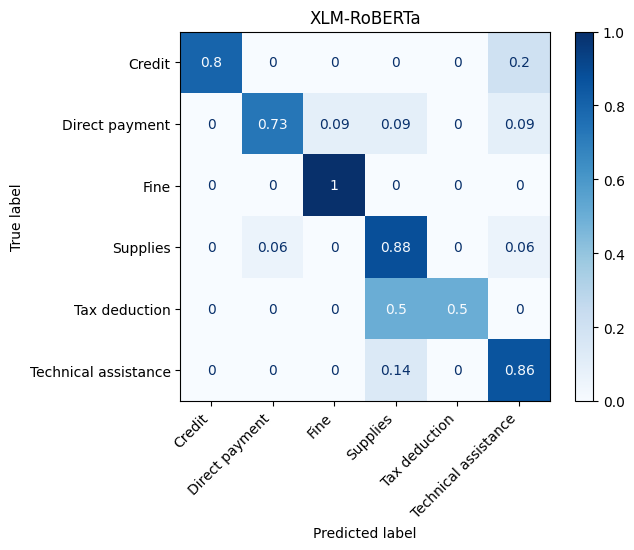

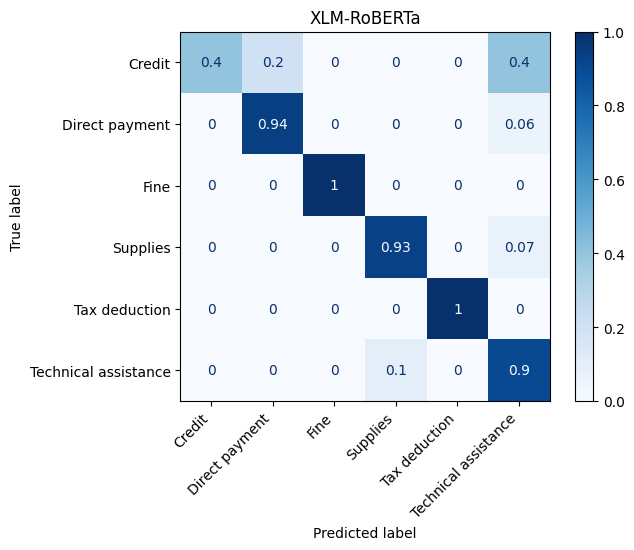

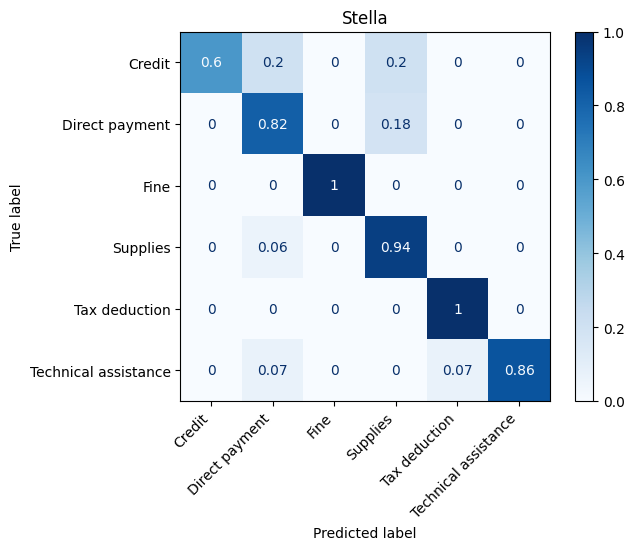

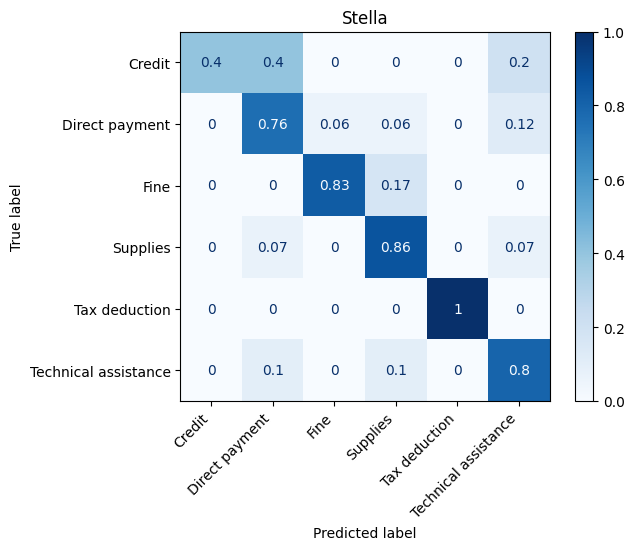

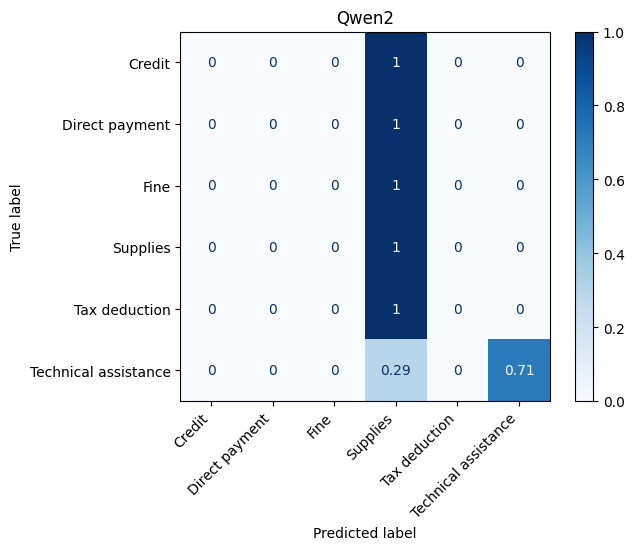

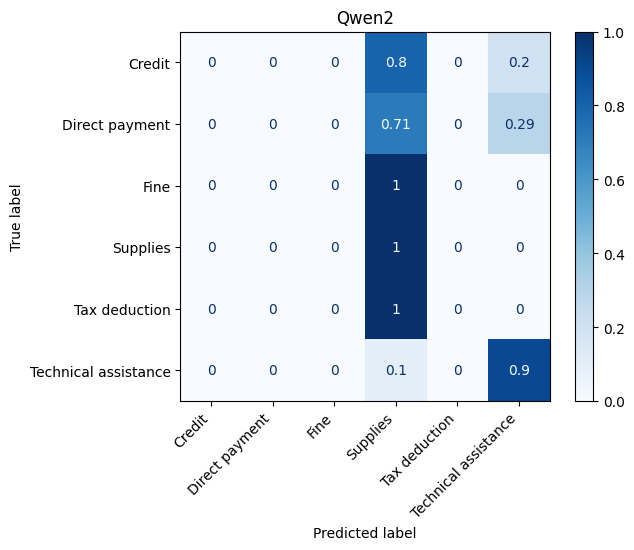

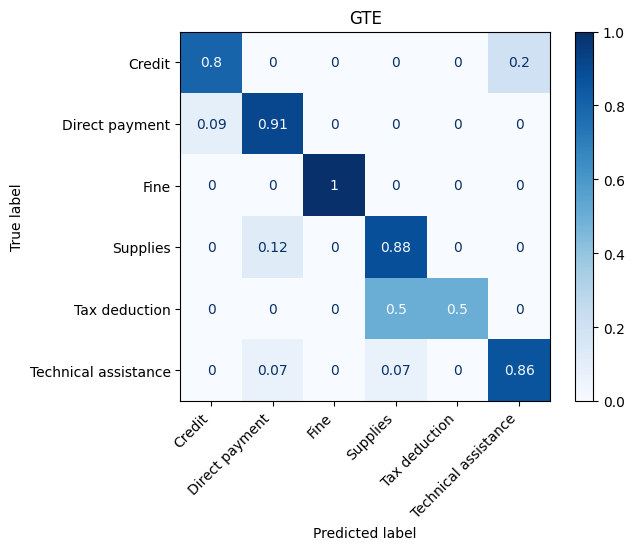

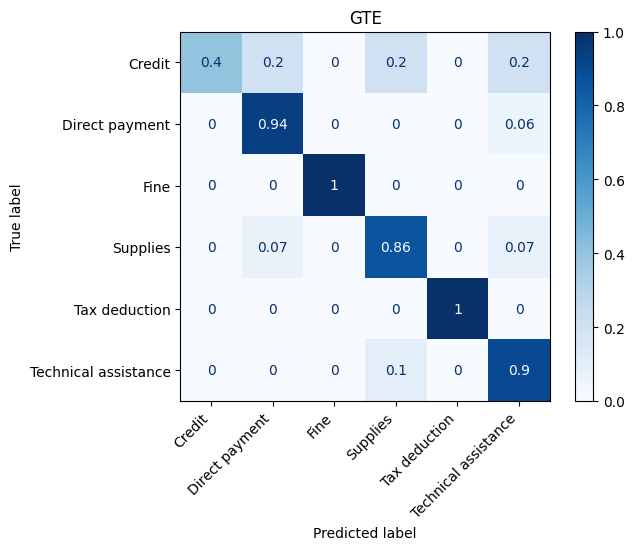

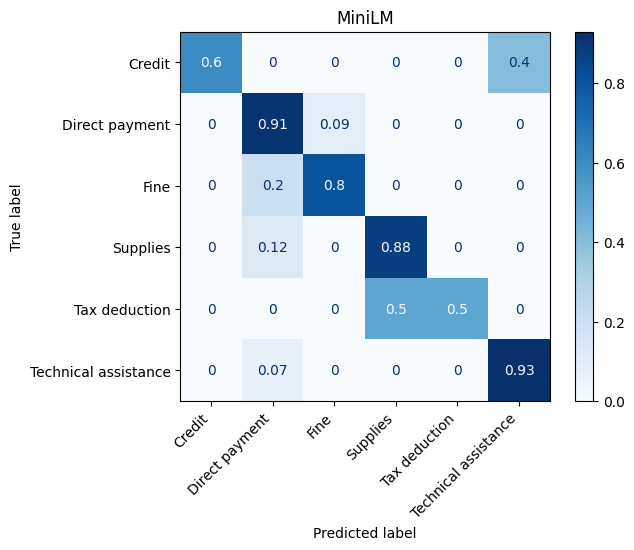

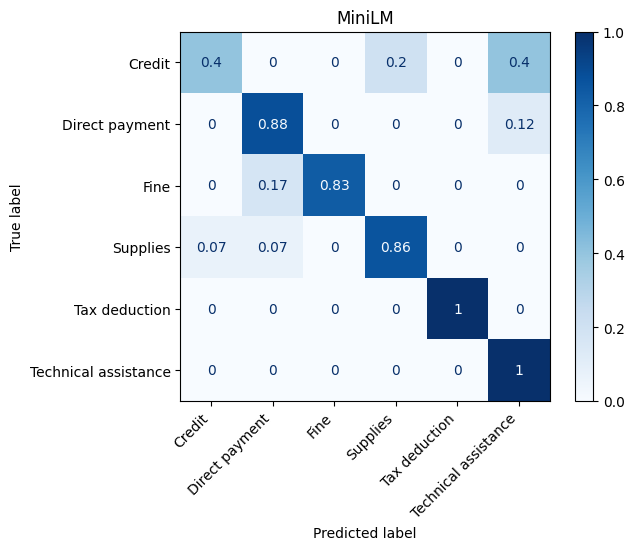

In [44]:
from sklearn import metrics
lbl_dct = {
    'bn': ["Incentive", "Non-Incentive"],
    'mc': ["Credit", "Direct payment", "Fine","Supplies","Tax deduction","Technical assistance"]
}
model_dct = {
    "bert":"XLM-RoBERTa", "stella":"Stella", "qwen":"Qwen2", "glarg":"GTE", "minilm":"MiniLM"
}
#for cls in list(rp_labels):
for cls in ['mc']:
    for model in list(rp_labels[cls]):
        #for exp in list(rp_labels[cls][model]):
        for exp in ['2', '5']:
            real = rp_labels[cls][model][exp]["real"]
            pred = rp_labels[cls][model][exp]["pred"]
            ###confusion_matrix = metrics.confusion_matrix(real, pred, normalize='true')
            confusion_matrix = metrics.confusion_matrix(real, pred)
            confusion_matrix= np.around(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis], decimals=2)
            try:
                cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=lbl_dct[cls])
                cm_display.plot(cmap=plt.cm.Blues)
                plt.title(f'{model_dct[model]} exp{exp}')
                plt.xticks(rotation=45, ha='right')
                plt.title(f'{model_dct[model]}')
                plt.show()
            except Exception as e:
                print(f"Issue in {model} exp{exp} due to {e}")

In [ ]:
models = {"sentence-transformers/paraphrase-xlm-r-multilingual-v1":'bert', "dunzhang/stella_en_1.5B_v5":'stella', "Alibaba-NLP/gte-Qwen2-1.5B-instruct":'qwen'}
model = SentenceTransformer(list(models)[0], device='cuda')
#dir(model)
vars(model)
#cfit
#'Required GPU Memory[Alibaba-NLP/gte-Qwen2-1.5B-instruct, precision: 32]: 7.94 GB'

{'prompts': {},
 'default_prompt_name': None,
 '_similarity_fn_name': None,
 'trust_remote_code': False,
 'truncate_dim': None,
 'model_card_data': SentenceTransformerModelCardData(language=[], license=None, model_name=None, model_id=None, train_datasets=[], eval_datasets=[], task_name='semantic textual similarity, semantic search, paraphrase mining, text classification, clustering, and more', tags=['sentence-transformers', 'sentence-similarity', 'feature-extraction'], generate_widget_examples='deprecated', base_model='sentence-transformers/paraphrase-xlm-r-multilingual-v1', base_model_revision='000e995b707ecea1b901208915ff3533783ec13d', non_default_hyperparameters={}, all_hyperparameters={}, eval_results_dict={}, training_logs=[], widget=[], predict_example=None, label_example_list=[], code_carbon_callback=None, citations={}, best_model_step=None, first_save=True, widget_step=-1, pipeline_tag='sentence-similarity', library_name='sentence-transformers', version={'python': '3.11.7', 'se

### ModelEvaluator

In [ ]:
lbl_dct = {
    'bn': ["incentive", "non-incentive"],
    'mc': ["Credit", "Direct_payment", "Fine","Supplies","Tax_deduction","Technical_assistance"]
}

for cls in list(rp_labels):
    for model in list(rp_labels[cls]):
        for exp in list(rp_labels[cls][model]):
            #try:
            numeric_real_labels = labels2numeric(rp_labels[cls][model][exp]['real'], lbl_dct[cls])
            #plot_data_distribution(numeric_train_labels, lbl_dct[cls])
            numeric_pred_labels = labels2numeric(rp_labels[cls][model][exp]['pred'], lbl_dct[cls])
            #evaluator = ModelEvaluator(lbl_dct[cls], y_true=numeric_real_labels, y_pred=numeric_pred_labels)
            #evaluator.plot_confusion_matrix(color_map='Blues')
            rpt = classification_report(rp_labels[cls][model][exp]['real'], rp_labels[cls][model][exp]['pred'], zero_division=1)
            print(f'\n{cls}{model}{exp}')
            print(rpt)
            #except Exception as e:
            #    print(f'{cls}{model}{exp}: {e}')


In [88]:
def genmets_df(report):
    for cls in list(report):
        print(f'\n{cls}')
        df = pd.DataFrame()
        for model in list(report[cls]):
            for metric in ['accuracy', "macroavg-f1", "weightavg-f1"]:
                df.loc[model,metric] = round(report[cls][model][metric]['average'],3)
        print(df)
        print('\n')

def labelf1_df(report):
    for cls in list(report):
        print(f'\n{cls}')
        df = pd.DataFrame()
        for model in list(report[cls]):
            for label in list(report[cls][model]['labels']):
                df.loc[model,label] = round(report[cls][model]['labels'][label]['average'],3)
        print(df)
        print('\n')

In [89]:
#for fn in ['exprpt_16Febx', 'exprpt_23Feb_dcno_only', 'exprpt_23Feb_qry_only', 'exprpt_23Feb_hitltrain_hptest', 'exprpt_23Feb_hptrain_hitltest']:
for fn in ['randp_16Febx', 'randp_23Feb_dcno_only', 'randp_23Feb_qry_only', 'randp_23Feb_hitltrain_hptest', 'randp_23Feb_hptrain_hitltest']:
  print(f'\n\n{fn}')
  with open(output_dir+f"/{fn}.json", 'r', encoding="utf-8") as outfile:
    #exp_rpt = json.load(outfile)
    randps = json.load(outfile)
  exp_rpt = cls_rpt_to_exp_rpt(res_dct_to_cls_rpt(randps))
  print('\naccuracy')
  genmets_df(exp_rpt)
  print('\nf1_score')
  labelf1_df(exp_rpt)



randp_16Febx


C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i


Could not add F1 score for Tax_deduction in mc bert exp:6

Could not add F1 score for Tax_deduction in mc bert exp:8

Could not add F1 score for Tax_deduction in mc stella exp:6

Could not add F1 score for Tax_deduction in mc stella exp:8

Could not add F1 score for Tax_deduction in mc qwen exp:0

Could not add F1 score for Tax_deduction in mc qwen exp:6

Could not add F1 score for Tax_deduction in mc qwen exp:8

Could not add F1 score for Tax_deduction in mc glarg exp:0

Could not add F1 score for Tax_deduction in mc glarg exp:6

Could not add F1 score for Tax_deduction in mc glarg exp:8

Could not add F1 score for Tax_deduction in mc minilm exp:0

Could not add F1 score for Tax_deduction in mc minilm exp:6

Could not add F1 score for Tax_deduction in mc minilm exp:8

accuracy

bn
        accuracy  macroavg-f1  weightavg-f1
bert       0.872        0.774         0.867
stella     0.850        0.743         0.847
qwen       0.810        0.448         0.725
glarg      0.880        0.796 

C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i


accuracy

bn
        accuracy  macroavg-f1  weightavg-f1
bert       0.915        0.796         0.913
stella     0.901        0.748         0.894
qwen       0.872        0.466         0.812
glarg      0.925        0.817         0.922
minilm     0.909        0.764         0.902



mc
        accuracy  macroavg-f1  weightavg-f1
bert       0.850        0.831         0.840
stella     0.733        0.666         0.726
qwen       0.250        0.074         0.110
glarg      0.854        0.848         0.853
minilm     0.796        0.747         0.788



f1_score

bn
        incentive  non-incentive
bert        0.641          0.952
stella      0.552          0.944
qwen        0.000          0.931
glarg       0.677          0.957
minilm      0.580          0.948



mc
        Credit  Direct_payment   Fine  Supplies  Tax_deduction  \
bert     0.807           0.840  0.796     0.916          0.980   
stella   0.559           0.711  0.842     0.769          0.443   
qwen     0.000           0.050  0.

C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i


Could not add F1 score for Tax_deduction in mc bert exp:1

Could not add F1 score for Tax_deduction in mc bert exp:2

Could not add F1 score for Credit in mc bert exp:4

Could not add F1 score for Tax_deduction in mc bert exp:6

Could not add F1 score for Credit in mc bert exp:9

Could not add F1 score for Tax_deduction in mc bert exp:9

Could not add F1 score for Tax_deduction in mc stella exp:1

Could not add F1 score for Tax_deduction in mc stella exp:2

Could not add F1 score for Credit in mc stella exp:4

Could not add F1 score for Tax_deduction in mc stella exp:6

Could not add F1 score for Credit in mc stella exp:9

Could not add F1 score for Tax_deduction in mc stella exp:9

Could not add F1 score for Tax_deduction in mc qwen exp:1

Could not add F1 score for Tax_deduction in mc qwen exp:2

Could not add F1 score for Credit in mc qwen exp:4

Could not add F1 score for Tax_deduction in mc qwen exp:6

Could not add F1 score for Credit in mc qwen exp:9

Could not add F1 score for

C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i


accuracy

bn
        accuracy  macroavg-f1  weightavg-f1
bert       0.840        0.703         0.850
stella     0.814        0.693         0.833
qwen       0.864        0.463         0.800
glarg      0.870        0.758         0.878
minilm     0.860        0.740         0.868



mc
        accuracy  macroavg-f1  weightavg-f1
bert       0.792        0.775         0.789
stella     0.733        0.732         0.732
qwen       0.375        0.178         0.228
glarg      0.867        0.855         0.865
minilm     0.833        0.840         0.829



f1_score

bn
        incentive  non-incentive
bert        0.502          0.905
stella      0.500          0.885
qwen        0.000          0.927
glarg       0.593          0.923
minilm      0.562          0.917



mc
        Credit  Direct_payment   Fine  Supplies  Tax_deduction  \
bert     0.714           0.750  0.690     0.889          0.857   
stella   0.690           0.700  0.750     0.779          0.769   
qwen     0.000           0.000  0.

C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i


accuracy

bn
        accuracy  macroavg-f1  weightavg-f1
bert       0.778        0.744         0.783
stella     0.762        0.702         0.758
qwen       0.712        0.416         0.592
glarg      0.762        0.730         0.769
minilm     0.789        0.744         0.789



mc
        accuracy  macroavg-f1  weightavg-f1
bert       0.811        0.828         0.812
stella     0.733        0.730         0.737
qwen       0.339        0.084         0.172
glarg      0.939        0.926         0.939
minilm     0.856        0.825         0.858



f1_score

bn
        incentive  non-incentive
bert        0.652          0.837
stella      0.568          0.835
qwen        0.000          0.832
glarg       0.637          0.822
minilm      0.637          0.851



mc
        Credit  Direct_payment   Fine  Supplies  Tax_deduction  \
bert     0.800           0.687  0.909     0.853          0.909   
stella   0.727           0.605  0.700     0.844          0.800   
qwen     0.000           0.000  0.

C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [91]:
fn='randp_16Febx'
with open(output_dir+f"/{fn}.json", 'r', encoding="utf-8") as outfile:
    #exp_rpt = json.load(outfile)
    randps = json.load(outfile)
res_dct_to_cls_rpt(randps)

C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

{'bn': {'bert': {'0': {'incentive': {'precision': 0.7647058823529411,
     'recall': 0.6964285714285714,
     'f1-score': 0.7289719626168224,
     'support': 56.0},
    'non-incentive': {'precision': 0.927038626609442,
     'recall': 0.9473684210526315,
     'f1-score': 0.9370932754880694,
     'support': 228.0},
    'accuracy': 0.897887323943662,
    'macro avg': {'precision': 0.8458722544811916,
     'recall': 0.8218984962406015,
     'f1-score': 0.833032619052446,
     'support': 284.0},
    'weighted avg': {'precision': 0.8950293530940756,
     'recall': 0.897887323943662,
     'f1-score': 0.8960552701331757,
     'support': 284.0}},
   '1': {'incentive': {'precision': 0.78125,
     'recall': 0.4807692307692308,
     'f1-score': 0.5952380952380952,
     'support': 52.0},
    'non-incentive': {'precision': 0.8928571428571429,
     'recall': 0.9698275862068966,
     'f1-score': 0.9297520661157025,
     'support': 232.0},
    'accuracy': 0.8802816901408451,
    'macro avg': {'precisio